In [1]:
%pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import ortools
import numpy as np
import pandas as pd
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

In [3]:
def plot_vertxs(vertexs):
  for item in vertexs:
      plt.plot(item)
  plt.show()

In [4]:
def read_file(path):
    print(path)

    file = open(path, 'r')
    for line in file:
        n, k = line.split()
        break

    df = pd.read_csv(path, sep=' ', header=None, skiprows=1)
    all_ver=df.to_numpy()
    # display(df)
    # print(df.to_numpy())

    # for item in df.to_numpy():
    #   plt.plot(item)

    return  n, k,all_ver, path

In [16]:
def has_conflict(a,b):
  state=[]
  k=len(a)
  for index in range(k):
    if(a[index]==b[index]): 
      state.append(0)
    elif(a[index]>b[index]):
      state.append(1)
    elif(a[index]<b[index]):
      state.append(2)
  bool_state=[]
  for i in range(len(state)):
    bool_state.append((i,(state[0]==state[i])))
  res=None
  for item in bool_state:
    if item[1]==False:
      res=item[0]
  
  return res,res!=None

In [17]:
def vers_conflict(vers):
  res={}
  for i in range(len(vers)):
    new_range=list(range(len(vers))).copy()
    new_range.remove(i)
    for j in new_range:
      item1=vers[i]
      item2=vers[j]
      hc=has_conflict(item1,item2)[1]
      if(hc==False and (j,i) not in res.keys()):
        res[(i,j)]=0
      elif((j,i) not in res.keys()):
        res[(i,j)]=1
  
  return res


In [18]:
def create_data_model(n,all_ver):
    """Create the data for the example."""
    data = {}
    weights = np.ones(n)
    data['weights'] = weights
    data['items'] = list(range(len(weights)))
    data['bins'] =data['items']
    data['has_conflicts']=vers_conflict(all_ver)
    data['bin_capacity'] = n
    # print(data['has_conflicts'])
    return data

In [19]:
from ortools.linear_solver import pywraplp
def optimize(n, k,all_ver, path):
  data = create_data_model(int(n),all_ver)

  # Create the mip solver with the SCIP backend.
  solver = pywraplp.Solver.CreateSolver('SCIP')

  if not solver:
      print('Solver init error')

  # Variables
  # x[i, j] = 1 if item i is packed in bin j.
  x = {}
  for i in data['items']:
      for j in data['bins']:
          x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))
  
  # y[j] = 1 if bin j is used.
  y = {}
  for j in data['bins']:
      y[j] = solver.IntVar(0, 1, 'y[%i]' % j)

  # Constraints
  # Each item must be in exactly one bin.
  for i in data['items']:
      solver.Add(sum(x[i, j] for j in data['bins']) == 1)

  # The amount packed in each bin cannot exceed its capacity.
  for j in data['bins']:
      solver.Add(
          sum(x[(i, j)] * data['weights'][i] for i in data['items']) <= y[j] *
          data['bin_capacity'])

  # conflicts constraint
  for bin in data['bins']:
    bin_items_index=[]
    for value in x.keys():
      if value[1]==bin:
        bin_items_index.append(value[0])
        pass
      pass
    for i1 in bin_items_index:
      new_items=bin_items_index.copy()
      new_items.remove(i1)
      for i2 in new_items:
        if ((i1,i2)  in data['has_conflicts'].keys()):
          if(data['has_conflicts'][(i1,i2)]==1):
            # print('conflict')
            solver.Add(sum(x[index,bin] for index in [i1,i2])<=1)  
        pass
      pass
    pass
  pass



  # Objective: minimize the number of bins used.
  solver.Minimize(solver.Sum([y[j] for j in data['bins']]))

  status = solver.Solve()



  if status == pywraplp.Solver.OPTIMAL:
    num_bins = 0
    for j in data['bins']:
        if y[j].solution_value() == 1:
            bin_items = []
            bin_weight = 0
            for i in data['items']:
                if x[i, j].solution_value() > 0:
                    bin_items.append(i)
                    bin_weight += data['weights'][i]
            if bin_items:
                num_bins += 1
                print('Bin number', j)
                bin_children=[all_ver[i] for i in bin_items]
                print('  Items packed:', bin_children)
                plot_vertxs(bin_children)
                print('  Total weight:', bin_weight)
                print()
    print()
    print('Number of bins used:', num_bins)
    print('Time = ', solver.WallTime(), ' milliseconds')
  else:
      print('The problem does not have an optimal solution.')

01
Bin number 0
  Items packed: [array([1, 2, 3, 4]), array([2, 3, 4, 6])]


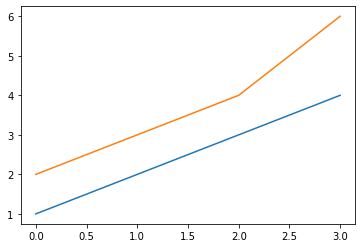

  Total weight: 2.0

Bin number 1
  Items packed: [array([6, 5, 4, 3])]


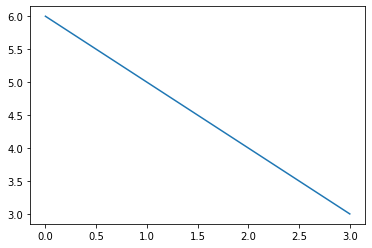

  Total weight: 1.0


Number of bins used: 2
Time =  451  milliseconds
02
Bin number 0
  Items packed: [array([4, 5, 4])]


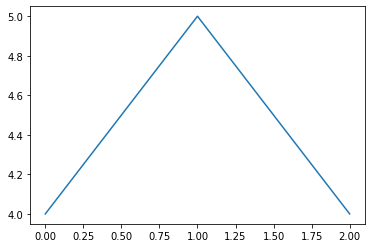

  Total weight: 1.0

Bin number 1
  Items packed: [array([4, 4, 6])]


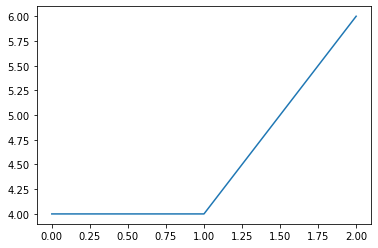

  Total weight: 1.0

Bin number 2
  Items packed: [array([5, 5, 5])]


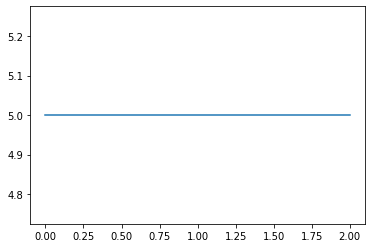

  Total weight: 1.0


Number of bins used: 3
Time =  421  milliseconds
03
Bin number 0
  Items packed: [array([5, 4]), array([4, 1])]


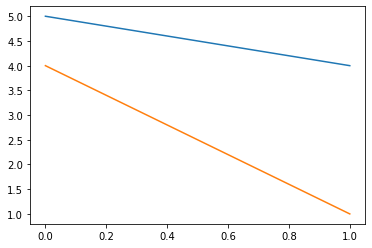

  Total weight: 2.0

Bin number 1
  Items packed: [array([1, 1]), array([2, 2]), array([4, 4])]


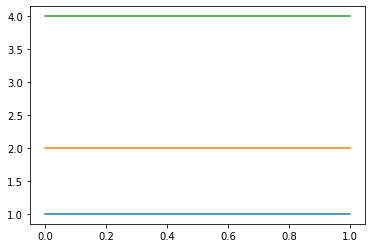

  Total weight: 3.0


Number of bins used: 2
Time =  313  milliseconds


In [25]:
for item in range(1,4):
  path =  str(item).zfill(2)
  optimize(*read_file(path))  